In [1]:
!nvidia-smi
%matplotlib inline

Wed Sep 10 16:19:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:31:00.0 Off |                    0 |
| N/A   29C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any, Optional
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

from ragas.llms import LangchainLLMWrapper
from langchain_deepseek import ChatDeepSeek
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import AnswerAccuracy
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

#### Loading the HotpotQA sample

In [3]:
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [4]:
HotpotQA_sample = load_dataset(
    "json",
    data_files="hotpot_sample_raw.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

Generating train split: 0 examples [00:00, ? examples/s]

## Using the off-the-shelf Qwen3-4B for classification

#### Prompt setting

In [5]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

#### Loading the model

In [6]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda


## Helper functions

In [7]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=5,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['question']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

def merge_df_into_dataset_by_order(dataset, df: pd.DataFrame, 
                                   columns=None, prefix: str="", inplace=False):
    """
    将 DataFrame 的指定列，按行顺序写回 HuggingFace Dataset。
    要求：df 与 dataset 行顺序一致、长度相同。
    """
    if columns is None:
        # 默认把 df 的所有列都写回（可用 prefix 避免重名）
        columns = list(df.columns)

    if len(df) != len(dataset):
        raise ValueError(f"Length mismatch: df={len(df)} vs dataset={len(dataset)}.")

    # 将 NaN -> None，并转成 Python 原生类型列表
    columns_dict = {}
    for col in columns:
        series = df[col]
        # 统一把 NaN 转成 None
        values = series.where(series.notna(), None).tolist()
        columns_dict[f"{prefix}{col}"] = values

    # 你已有的工具函数
    updated_dataset = add_columns_to_dataset(dataset, columns_dict, inplace=inplace)
    return updated_dataset

#### Direct classification with Qwen3-4B

In [8]:
df_HotpotQA_sample = pd.read_json("hotpot_sample_raw.jsonl", lines=True)
test_prompts = prepare_test_prompts(df_HotpotQA_sample, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1000
Generation complete: 1000 prompts
Average prompt length: 405 bytes (~101 tokens)

Analyze the following input user query:

{"query": "What nationality was Oliver Reed's character in the film Royal Flash?"}

Please provide your analysis in the following JSON format:

{"query": "What nationality was Oliver Reed's character in the film Royal Flash?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [9]:
test_df = run_experiment(test_prompts, df_HotpotQA_sample)
test_df.to_csv('BASELINE_HotpotQA_classification_all.csv')
test_df

100%|██████████| 200/200 [2:15:11<00:00, 40.56s/it]  


,id,question,answer,thinking,model_response,model_pred
0,5add1d575542992c1e3a2540,What nationality was Oliver Reed's character i...,[Prussian],"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What nationality was Oliver Ree...",fully specified
1,5ac55ea55542993e66e82377,Pacific Mozart Ensemble performed which German...,[Kurt Julian Weill],"<think>\nOkay, let me try to figure this out. ...","{\n ""query"": ""Pacific Mozart Ensemble perform...",fully specified
2,5ac3a76e554299741d48a2be,"Who released the song ""With or Without You"" fi...",[U2],"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Who released the song \""With or...",fully specified
3,5a7133565542994082a3e65c,"What Kentucky county has a population of 60,31...",[Oldham County],"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""What Kentucky county has a popu...",fully specified
4,5ac1a4745542991316484b82,"Para Hills West, South Australia lies within a...","[138,535]","<think>\nOkay, let's see. The user is asking a...","{\n ""query"": ""Para Hills West, South Australi...",fully specified
...,...,...,...,...,...,...
995,5a8b46925542995d1e6f133c,When was the singer of Miss Emily's Picture born?,"[August 11, 1946]","<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""When was the singer of Miss Emi...",underspecified
996,5a808cbd5542996402f6a54b,What is the profession of Ansel Elgort's chara...,[getaway driver],"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What is the profession of Ansel...",fully specified
997,5ab1e7685542993be8fa9877,On what street was the hotel located where the...,[Peachtree Street],"<think>\nOkay, let's tackle this query step by...","{\n ""query"": ""On what street was the hotel lo...",underspecified
998,5a865d11554299211dda2b0d,What is the original name of the place where T...,[Fort Saint Anthony],"<think>\nOkay, let's see. I need to figure out...","{\n ""query"": ""What is the original name of th...",underspecified


In [10]:
annotated_dataset = merge_df_into_dataset_by_order(
    HotpotQA_sample, 
    test_df, 
    columns=["thinking", "model_response", "model_pred"],
    prefix="qwen3_",
    inplace=False
)

In [11]:
# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("BASELINE_classified_HotpotQA_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("BASELINE_classified_HotpotQA_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("BASELINE_classified_HotpotQA_sample_FS.jsonl", orient="records", lines=True)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 496
Fully specified samples: 504


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1603912

# QA implementations

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_HotpotQA_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_HotpotQA_sample_FS.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Loading GPT for short QA

In [ ]:
from openai import OpenAI

client = OpenAI() # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return ["[Error]: Max retries exceeded"]

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

In [6]:
def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=5, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

## Implementations

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 100/100 [04:53<00:00,  2.94s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 101/101 [04:14<00:00,  2.52s/it]


In [9]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])

qa_underspecified.to_json("BASELINE_HotpotQA_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1689887

In [10]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])
    
qa_fully_specified.to_json("BASELINE_HotpotQA_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1627760

In [11]:
df = pd.read_json("BASELINE_HotpotQA_UND_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_HotpotQA_UND_qa_gpt.csv')

df = pd.read_json("BASELINE_HotpotQA_FS_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_HotpotQA_FS_qa_gpt.csv')

# Evaluations

In [12]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_FS_qa_gpt.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Squad EM + F1

In [13]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="BASELINE_HotpotQA_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["answer"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 42.06
F1 Score: 56.14


In [14]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="BASELINE_HotpotQA_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["answer"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 21.98
F1 Score: 34.33


In [15]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="answer"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [16]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("BASELINE_HotpotQA_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1698542

In [17]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("BASELINE_HotpotQA_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1636555

In [18]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 21.98
UND F1 Score (avg): 34.64
FS Exact Match (avg): 42.46
FS F1 Score (avg): 56.65
F1: t=8.254, p=0.0000
EM: t=7.101, p=0.0000


In [19]:
UND_full = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
df = pd.read_json("BASELINE_HotpotQA_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_HotpotQA_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("BASELINE_HotpotQA_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_HotpotQA_FS_qa_gpt_with_squad_scores.csv')

In [3]:
print(f'gpt_4o HotpotQA NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o HotpotQA NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o HotpotQA NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o HotpotQA NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o HotpotQA NQ UND qa EM SD: 0.4147941208530088
gpt_4o HotpotQA NQ FS qa EM SD: 0.48762306433639085
gpt_4o HotpotQA NQ UND qa F1 SD: 0.4079821779434008
gpt_4o HotpotQA NQ FS qa F1 SD: 0.43666341470616715


In [4]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [5]:
welch_df(394, np.std(UND_full["em"]), 606, np.std(FS_full["em"]))

929.2090378182792

In [6]:
welch_df(394, np.std(UND_full["f1"]), 606, np.std(FS_full["f1"]))

879.495758403792

## Visualization

In [21]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset_BASELINE - HotpotQA")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("HotpotQA_f1_boxplot_gpt_BASELINE.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset_BASELINE (± CI) - HotpotQA")
plt.tight_layout()
plt.savefig("HotpotQA_em_barplot_gpt_BASELINE.png",dpi=300)
plt.close()

/scratch-local/yhuang.14605433/ipykernel_3784257/3247511758.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.14605433/ipykernel_3784257/3247511758.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.14605433/ipykernel_3784257/3247511758.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


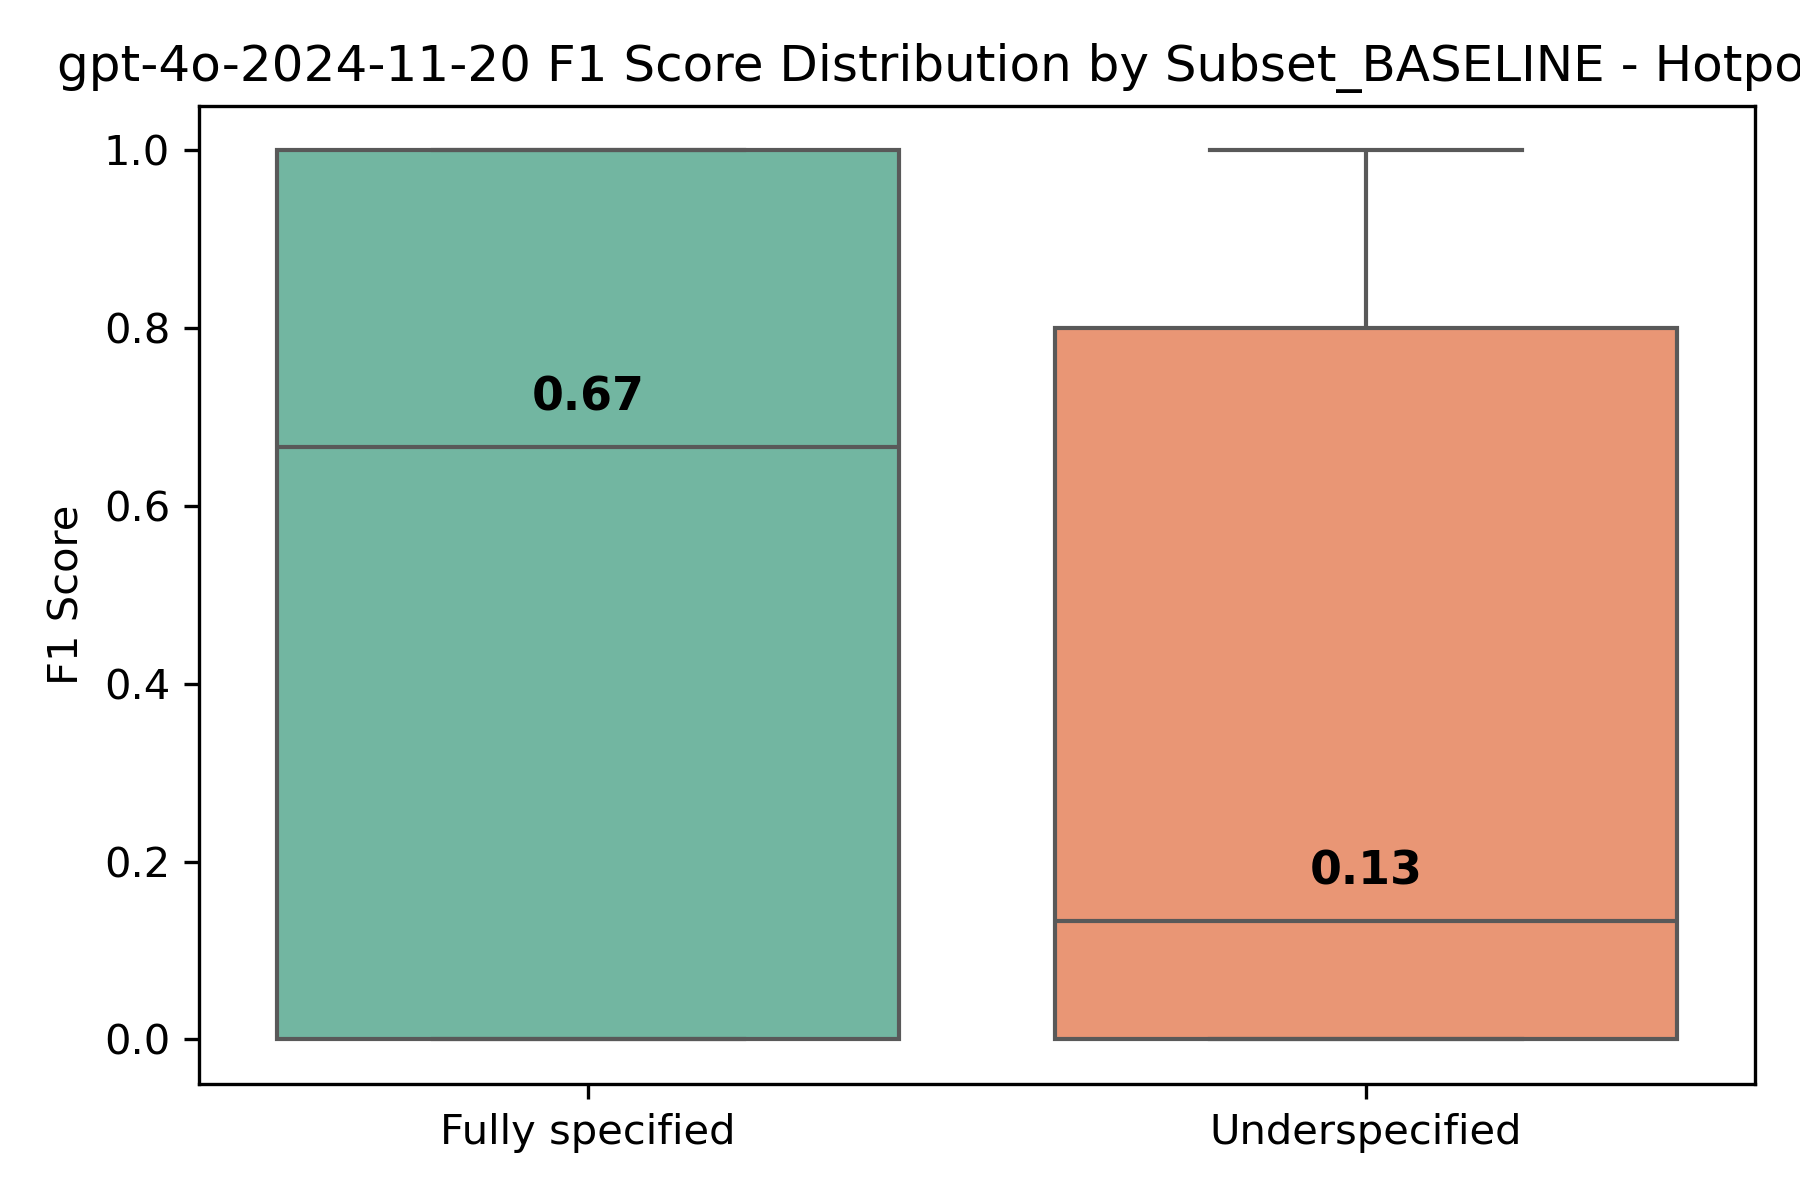

In [22]:
from IPython.display import Image
Image("HotpotQA_f1_boxplot_gpt_BASELINE.png")

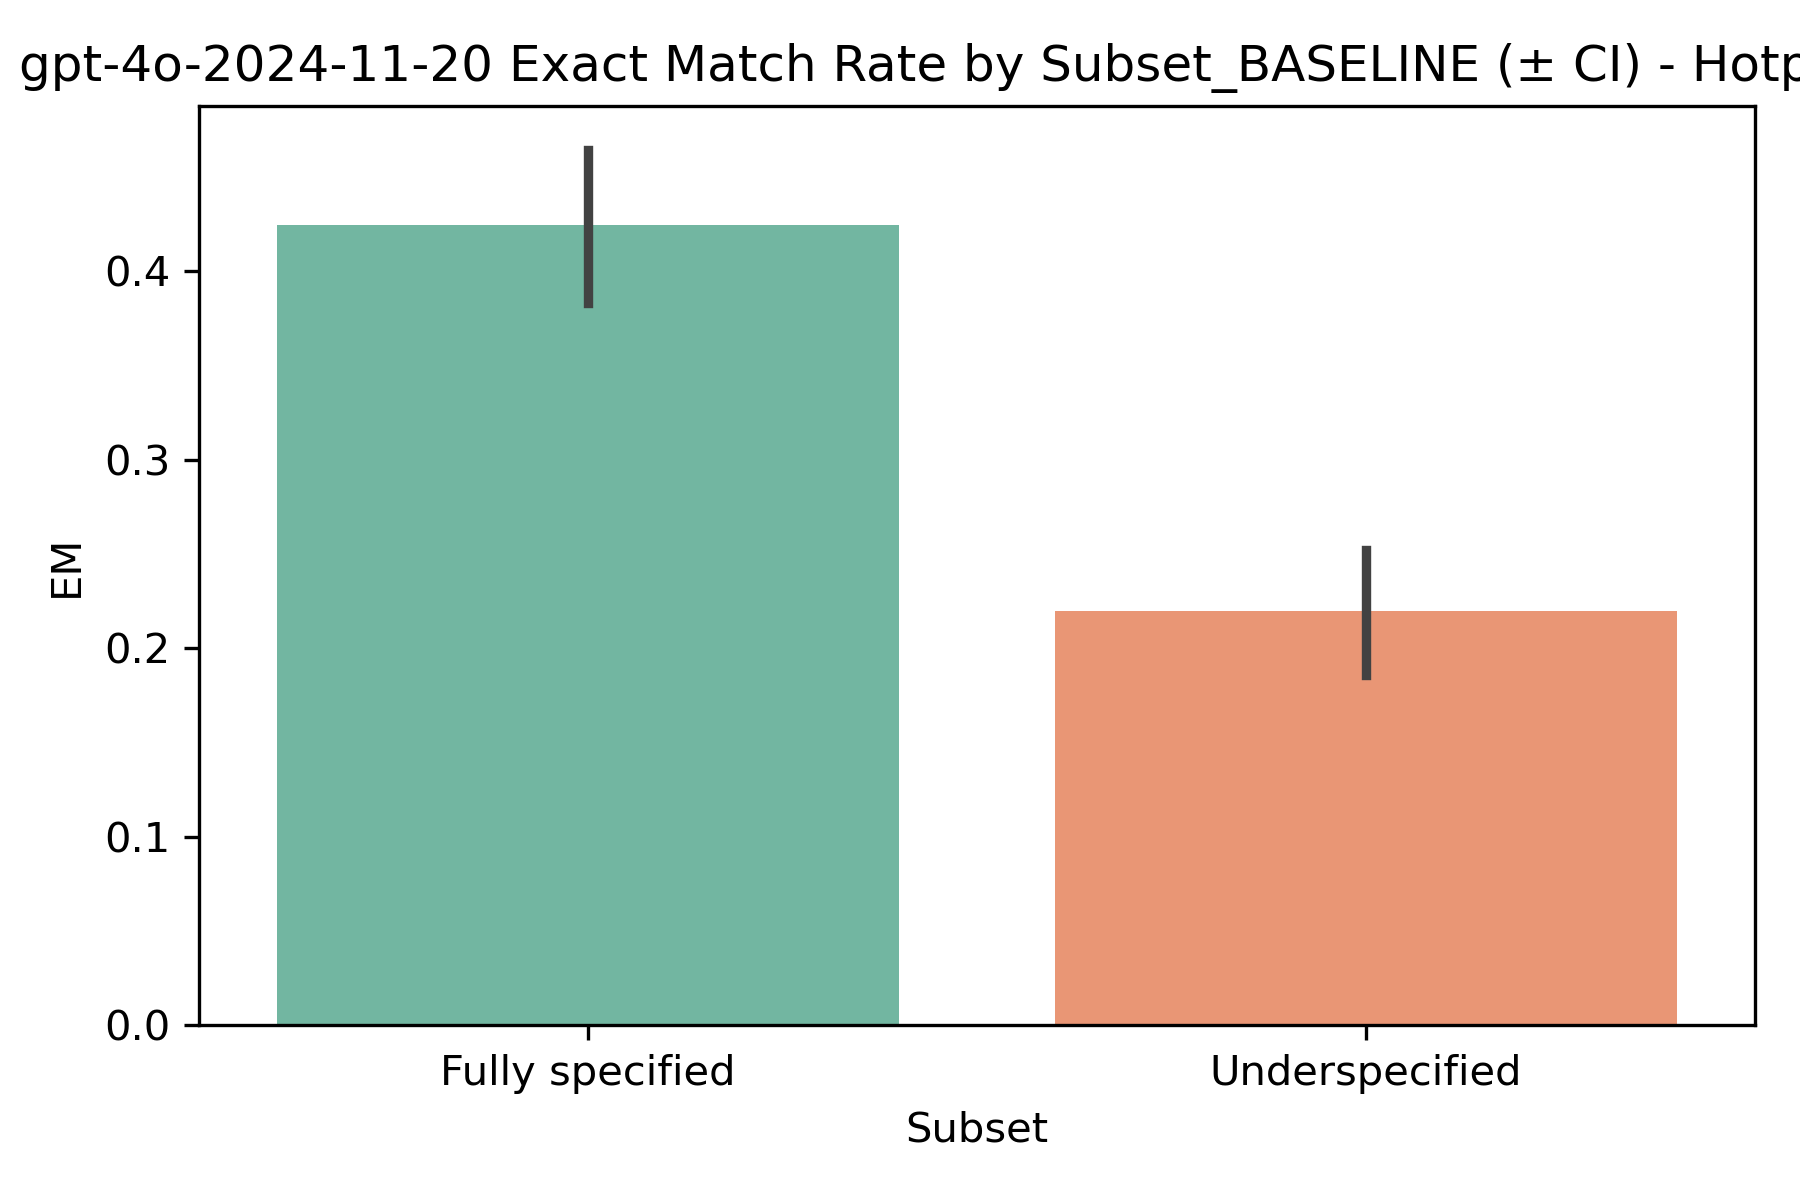

In [23]:
Image("HotpotQA_em_barplot_gpt_BASELINE.png")

### Ragas Evaluations

In [3]:
evaluator_llm = LangchainLLMWrapper(ChatDeepSeek(model="deepseek-chat", verbose=True, temperature=0))

UND_full = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_HotpotQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
async def test_single_sample(row, evaluator=evaluator_llm):
    """测试单个样本的评分"""
    scorer = AnswerAccuracy(llm=evaluator)
    
    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
    reference_answers = row['answer'] if isinstance(row['answer'], list) else [row['answer']]
    
    print(f"模型答案: {model_answers}")
    print(f"参考答案: {reference_answers}")
    
    max_score = 0.0
    best_combination = None
    
    for i, model_ans in enumerate(model_answers):
        for j, ref_ans in enumerate(reference_answers):
            sample = SingleTurnSample(
                user_input=row['question'],
                response=model_ans,
                reference=ref_ans
            )
            score = await scorer.single_turn_ascore(sample)
            print(f"组合 {i+1}-{j+1}: 分数 = {score}")
            
            if score > max_score:
                max_score = score
                best_combination = (model_ans, ref_ans)
    
    print(f"最高分数: {max_score}")
    print(f"最佳组合: {best_combination}")
    return max_score

# 测试使用
test_score = await test_single_sample(UND_full[0])

模型答案: ['1949']
参考答案: ['1959']
组合 1-1: 分数 = 0.0
最高分数: 0.0
最佳组合: None


In [8]:
async def answer_accuracy(input_dataset, long_answer=False, evaluator=evaluator_llm):
    # 在函数开始时创建一次 scorer
    scorer = AnswerAccuracy(llm=evaluator)
    
    if long_answer:
        score_list_long = []
        score_list_short = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short and long answer accuracy")):
            try:
                # 长答案评分
                if 'model_long_answer' in row and 'long_answer' in row:
                    sample_long = SingleTurnSample(
                        user_input=row['question'],
                        response=row['model_long_answer'],
                        reference=row['long_answer']
                    )
                    score_long = await scorer.single_turn_ascore(sample_long)
                    score_list_long.append(score_long)
                else:
                    score_list_long.append(0.0)

                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'answer' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['answer'] if isinstance(row['answer'], list) else [row['answer']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample_short = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample_short)
                            max_score = max(max_score, score)
                    
                    score_list_short.append(max_score)
                else:
                    score_list_short.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list_long.append(0.0)
                score_list_short.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_long", score_list_long)
        ragas_scored_dataset = ragas_scored_dataset.add_column("ragas_AA_short", score_list_short)

        return ragas_scored_dataset
    else:
        score_list = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short answer accuracy")):
            try:
                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'answer' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['answer'] if isinstance(row['answer'], list) else [row['answer']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample)
                            max_score = max(max_score, score)
                    
                    score_list.append(max_score)
                else:
                    score_list.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_short", score_list)

        return ragas_scored_dataset

In [9]:
UND_ragas = await answer_accuracy(UND_full)
UND_ragas.to_csv("HotpotQA_UND_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 496/496 [1:16:07<00:00,  9.21s/it]


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1629216

In [10]:
FS_ragas = await answer_accuracy(FS_full)
FS_ragas.to_csv("HotpotQA_FS_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 504/504 [1:17:17<00:00,  9.20s/it]


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1565471

In [11]:
UND_ragas_AA = list(UND_ragas["ragas_AA_short"])
FS_ragas_AA = list(FS_ragas["ragas_AA_short"])

UND_mean_AA = np.mean(UND_ragas_AA)
print(f"UND AA (avg): {UND_mean_AA * 100:.2f}")


FS_mean_AA = np.mean(FS_ragas_AA)
print(f"FS AA (avg): {FS_mean_AA * 100:.2f}")

AA_tstat, AA_pval = ttest_ind(FS_ragas_AA, UND_ragas_AA, equal_var=False)
print(f"AA: t={AA_tstat:.3f}, p={AA_pval:.4f}")

UND AA (avg): 42.19
FS AA (avg): 65.43
AA: t=8.096, p=0.0000
